# wps_CI_ClimatEx

#### wps_CI is a process that runs the [ci.netcdf.wrapper](https://github.com/pacificclimate/ClimDown/blob/master/R/CI.R#L235) function of [ClimDown](https://cran.r-project.org/web/packages/ClimDown/index.html) package. This notebook is structured similarly to `wps_CI_demo.ipynb`, but it uses the monthly climatologies computed from the gridded observations in `tiny_obs.nc` as the `obs_file` parameter. This skips the computation of the climatologies during Climate Imprint. To get started, first instatiate the client. Here, the client will try to connect to a chickadee instance using the url parameter.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from birdy import WPSClient
from wps_tools.testing import get_target_url
from pkg_resources import resource_filename
from tempfile import NamedTemporaryFile
from netCDF4 import Dataset, num2date

# Ensure we are in the working directory with access to the data
while os.path.basename(os.getcwd()) != "chickadee":
    os.chdir('../')

In [2]:
# NBVAL_IGNORE_OUTPUT
#url = get_target_url("chickadee")
url = "http://localhost:5003/wps" # Use the instance of the bird running on another terminal
print(f"Using chickadee on {url}")

Using chickadee on http://localhost:5003/wps


In [3]:
chickadee = WPSClient(url)

#### Help for individual processes can be diplayed using the ? command (ex. bird.process?).

In [4]:
# NBVAL_IGNORE_OUTPUT
chickadee.ci?

Signature:
chickadee.ci(
    gcm_file,
    obs_file=None,
    varname=None,
    num_cores='4',
    loglevel='INFO',
    units_bool=True,
    n_pr_bool=True,
    tasmax_units='celsius',
    tasmin_units='celsius',
    pr_units='kg m-2 d-1',
    max_gb=1.0,
    start_date=datetime.date(1971, 1, 1),
    end_date=datetime.date(2005, 12, 31),
    out_file=None,
)
Docstring:
Climate Imprint (CI) downscaling

Parameters
----------
gcm_file : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
    Filename of GCM simulations
obs_file : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
    Filename of high-res gridded historical observations
varname : string
    Name of the NetCDF variable to downscale (e.g. 'tasmax')
out_file : string
    Filename to create with the climate imprint outputs
num_cores : {'1', '2', '3', '4'}positiveInteger
    The number of cores to use for parallel execution
loglevel : {'CRITICAL', 'ERROR', 'WARNING', 'IN

#### We can use the docstring to ensure we provide the appropriate parameters.

In [5]:
# Showcase the structure of the input gcm_file and target obs_file dataset
gcm_file = resource_filename("tests", "/data/tiny_gcm.nc")
obs_file = resource_filename("tests", "/data/tiny_clims.nc")
gcm_dataset = Dataset(gcm_file)
obs_dataset = Dataset(obs_file)
print("GCM Structure: " + str(gcm_dataset.dimensions.items()) + "\n")
print("Obs Structure: " + str(obs_dataset.dimensions.items()))

GCM Structure: dict_items([('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 4), ('nb2', <class 'netCDF4._netCDF4.Dimension'>: name = 'nb2', size = 2), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 4), ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 3651)])

Obs Structure: dict_items([('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 12), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 26), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 26)])


In [6]:
# Run CI using these example files
with NamedTemporaryFile(suffix=".nc", prefix="output_", dir="/tmp", delete=True) as out_file:
    output = chickadee.ci(
        gcm_file = gcm_file,
        obs_file = obs_file,
        out_file = out_file.name,
        varname = "tasmax",
        tasmax_units = "
    )

Access the output with nc_to_dataset() or auto_construct_outputs() from wps_tools.output_handling

In [7]:
# NBVAL_IGNORE_OUTPUT
from wps_tools.output_handling import nc_to_dataset, auto_construct_outputs

output_dataset = nc_to_dataset(output.get()[0])
output_dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): lon(26), lat(26), time(3651)
    variables(dimensions): float64 lon(lon), float64 lat(lat), float64 time(time), float32 tasmax(time, lat, lon)
    groups: 

In [8]:
# NBVAL_IGNORE_OUTPUT
auto_construct_outputs(output.get())

[<class 'netCDF4._netCDF4.Dataset'>
 root group (NETCDF3_CLASSIC data model, file format NETCDF3):
     dimensions(sizes): lon(26), lat(26), time(3651)
     variables(dimensions): float64 lon(lon), float64 lat(lat), float64 time(time), float32 tasmax(time, lat, lon)
     groups: ]

#### Once the process has completed we can extract the results and ensure it is what we expected.

In [9]:
expected_data = Dataset(resource_filename("tests", "/data/CI_expected_output.nc"))
print("Expected Output Structure: " + str(expected_data.dimensions.items()))
for key, value in expected_data.dimensions.items():
    assert str(output_dataset.dimensions[key]) == str(value)

Expected Output Structure: dict_items([('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 26), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 26), ('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 3651)])


In [10]:
# Also check that the tasmax values are nearly the same at a random time step.
# np.isclose is used to account for floating point approximation errors at high decimal places.
output_tasmax = output_dataset.variables["tasmax"][5,:,:]
expected_tasmax = expected_data.variables["tasmax"][5,:,:]
np.all(np.isclose(output_tasmax, expected_tasmax))

True

#### We can also visualize the inputs and outputs at random time steps using contour plots.

In [11]:
# Get dates of time steps in tiny_gcm.nc seperated by about three months
time_steps = [31, 124, 217, 309]
for step in time_steps:
    print(num2date(gcm_dataset.variables["time"][step], "days since 1950-01-01 00:00:00"))

1965-01-28 12:00:00
1965-05-01 12:00:00
1965-08-02 12:00:00
1965-11-02 12:00:00


In [12]:
def plot_row(gcm_data, output_data, ax1, ax2, time_step):
    gcm_lats = gcm_data.variables["lat"][:]
    gcm_lons = (gcm_data.variables["lon"][:] + 180) % 360 - 180 # Convert to (-180, 180) range
    gcm_tasmax = gcm_data.variables["tasmax"][time_step,:,:] - 273.15 # Convert from Kelvin to Celsius
    output_lats = output_data.variables["lat"][:]
    output_lons = output_data.variables["lon"][:]
    output_tasmax = output_data.variables["tasmax"][time_step,:,:]
    date = num2date(gcm_data.variables["time"][time_step], "days since 1950-01-01 00:00:00")
    cf1 = ax1.contourf(gcm_lons, gcm_lats, gcm_tasmax)
    ax1.set_title(f"tasmax (\N{DEGREE SIGN}C) for input GCM data in {date}")
    ax1.set_xlabel("lon")
    ax1.set_ylabel("lat")
    fig.colorbar(cf1, ax=ax1, shrink=0.8)
    cf2 = ax2.contourf(output_lons, output_lats, output_tasmax)
    ax2.set_title(f"tasmax (\N{DEGREE SIGN}C) for output data in {date}")
    ax2.set_xlabel("lon")
    ax2.set_ylabel("lat")
    fig.colorbar(cf2, ax=ax2, shrink=0.8)
    print(f"GCM tasmax range in {date}: [{np.min(gcm_tasmax)}, {np.max(gcm_tasmax)}]")
    print(f"Output tasmax range in {date}: [{np.nanmin(output_tasmax)}, {np.nanmax(output_tasmax)}]\n")

GCM tasmax range in 1965-01-28 12:00:00: [-36.78900146484375, -30.58514404296875]
Output tasmax range in 1965-01-28 12:00:00: [-31.00628089904785, -28.62691307067871]

GCM tasmax range in 1965-05-01 12:00:00: [-15.77850341796875, -4.96685791015625]
Output tasmax range in 1965-05-01 12:00:00: [-19.127941131591797, -15.60812759399414]

GCM tasmax range in 1965-08-02 12:00:00: [1.08062744140625, 10.8114013671875]
Output tasmax range in 1965-08-02 12:00:00: [9.04014778137207, 12.170183181762695]

GCM tasmax range in 1965-11-02 12:00:00: [-32.391357421875, -8.166900634765625]
Output tasmax range in 1965-11-02 12:00:00: [-29.858901977539062, -25.64495849609375]



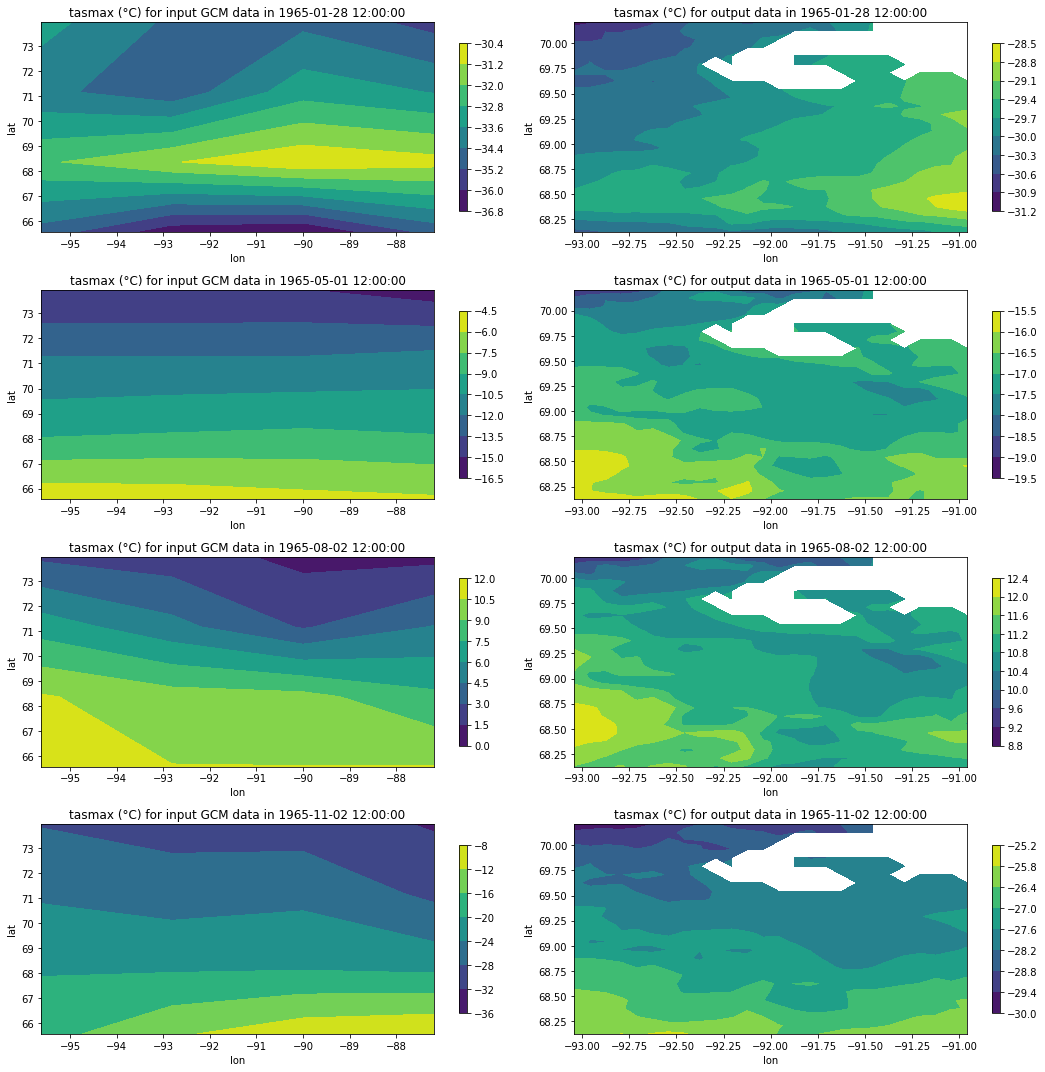

In [13]:
# Create contour plots for each time step
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
for (i, step) in enumerate(time_steps):
    plot_row(gcm_dataset, output_dataset, axes[i][0], axes[i][1], step)
plt.tight_layout()